In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import read_geolife
import tracers as tr
import matplotlib.pyplot as plt
from pyproj import Transformer
import math
import seaborn as sns
import os

In [44]:
root_path = "/mnt/d/maart18maxDist500noDROPv2"
perturbed_traces = []

space_noise, time_min_period = 100.0, 30 
traces = []
# Load and perturb traces user by user
for i in range(100):
    user_path = f'taxi_{i}'
    file_path = os.path.join(root_path, user_path)
    
    user_traces = []
    
    if os.path.exists(file_path):
        for file in os.scandir(file_path): 
            df = pd.read_csv(file, sep=",")
            
            # Convert timestamp to epoch, drop invalid timestamps
            df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="ISO8601", errors="coerce").astype(int) / 10**9
            df = df.dropna(subset=["Timestamp"])
            
            # Sort by time
            df = df.sort_values(by='Timestamp')

            trace = df[['Longitude', 'Latitude', 'Timestamp']].to_numpy()
            trace = [(x[0], x[1], int(x[2])) for x in trace]
            
            user_traces.append(trace)

    if user_traces:
        perturbed_user_traces = tr.perturb_traces((space_noise, time_min_period), user_traces, picker_str='closest')
        perturbed_traces.extend(perturbed_user_traces)
        traces.extend(user_traces)

print(f"Total perturbed traces: {len(perturbed_traces)}")


Total perturbed traces: 10321


In [45]:
lat_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9028, 12.4965)) * 10000
lon_meter_per_degree = tr.rs_geodesic_distance((41.9028, 12.4964),(41.9029, 12.4964)) * 10000
print("50 meter lat is: ", 10/lat_meter_per_degree, "°")
print("50 meter lon is: ", 10/lon_meter_per_degree, "°")
meter_per_degree = (lat_meter_per_degree + lon_meter_per_degree)/2
print(meter_per_degree)

50 meter lat is:  9.039443250896991e-05 °
50 meter lon is:  9.199689221384284e-05 °
109662.80313373724


In [46]:
from scipy import stats
lat_noise = []
lon_noise = []
angles = []
noise_distr = []

wgs84_to_utm = Transformer.from_crs(4326, 3065, always_xy=True)

for trace_idx in range(len(traces)):
    for point_idx in range(len(traces[trace_idx])):

        perturbed_traces_lon,perturbed_traces_lat = perturbed_traces[trace_idx][point_idx][0], perturbed_traces[trace_idx][point_idx][1]
        traces_lon,traces_lat = traces[trace_idx][point_idx][0], traces[trace_idx][point_idx][1]
        
        noise = tr.rs_geodesic_distance((perturbed_traces_lon,perturbed_traces_lat),(traces_lon,traces_lat))
        noise_distr.append(noise/meter_per_degree)

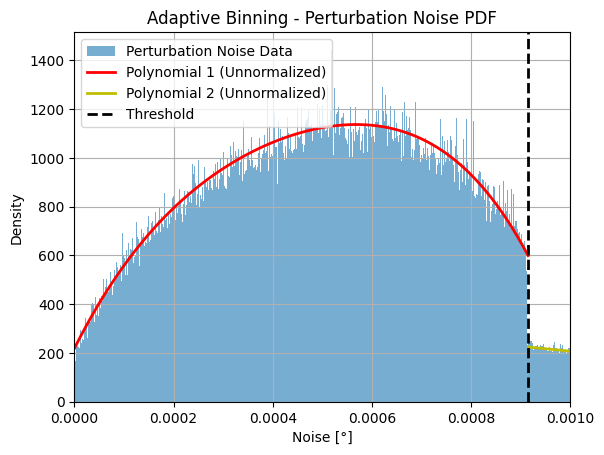

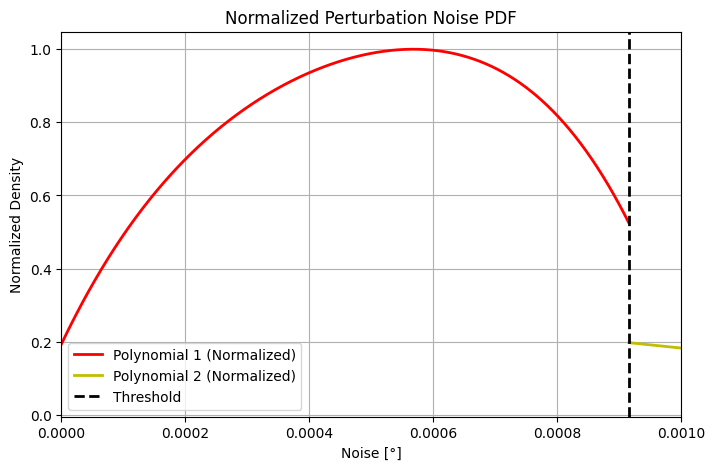

Normalization factor: 1136.8322787380832
Normalized Polynomial 1:
            4             3             2
-4.13e+12 x + 6.907e+09 x - 6.353e+06 x + 3558 x + 0.1925
Normalized Polynomial 2:
            2
5.184e+04 x - 274.8 x + 0.4052


In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Define threshold for finer binning
threshold = 0.000915

num_fine_bins = 1000  # More bins in the fine region
num_coarse_bins = 5000  # Fewer bins in the coarse region

fine_bins = np.linspace(0, threshold, num_fine_bins, endpoint=False)  # Small steps
coarse_bins = np.linspace(threshold, 0.0025, num_coarse_bins)  # Larger steps

# Combine bin edges (remove duplicate threshold value)
bin_edges = np.concatenate((fine_bins, coarse_bins[1:]))

# Generate histogram with custom bins
hist_values, _ = np.histogram(noise_distr, bins=bin_edges, density=True)

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

# Find boundary index
idx_boundary = np.searchsorted(bin_centers, threshold)

# Define x and y for fitting
x1, y1 = bin_centers[:idx_boundary], hist_values[:idx_boundary]
x2, y2 = bin_centers[idx_boundary:], hist_values[idx_boundary:]

# Fit polynomials
deg1 = 4   
deg2 = 2 

coeffs_1 = np.polyfit(x1, y1, deg1) if len(x1) > deg1 else None
coeffs_2 = np.polyfit(x2, y2, deg2) if len(x2) > deg2 else None

f_1 = np.poly1d(coeffs_1) if coeffs_1 is not None else None
f_2 = np.poly1d(coeffs_2) if coeffs_2 is not None else None

# Smooth values for plotting
x_smooth_1 = np.linspace(min(x1), max(x1), 5000) if f_1 else []
y_smooth_1 = f_1(x_smooth_1) if f_1 else []

x_smooth_2 = np.linspace(min(x2), max(x2), 5000) if f_2 else []
y_smooth_2 = f_2(x_smooth_2) if f_2 else []

# Compute max value for normalization
max_value = max(np.max(y_smooth_1), np.max(y_smooth_2)) if f_1 and f_2 else np.nan

# Plot histogram
plt.hist(noise_distr, bins=bin_edges, density=True, label="Perturbation Noise Data", alpha=0.6)

# Plot unnormalized polynomials
if f_1:
    plt.plot(x_smooth_1, y_smooth_1, 'r-', linewidth=2, label="Polynomial 1 (Unnormalized)")
if f_2:
    plt.plot(x_smooth_2, y_smooth_2, 'y-', linewidth=2, label="Polynomial 2 (Unnormalized)")

plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Noise [°]")
plt.ylabel("Density")
plt.title("Adaptive Binning - Perturbation Noise PDF")
plt.legend()
plt.xlim(0, 0.001)
plt.grid(True)
plt.show()

# Normalized plot
plt.figure(figsize=(8, 5))
if f_1:
    plt.plot(x_smooth_1, y_smooth_1 / max_value, 'r-', linewidth=2, label="Polynomial 1 (Normalized)")
if f_2:
    plt.plot(x_smooth_2, y_smooth_2 / max_value, 'y-', linewidth=2, label="Polynomial 2 (Normalized)")

plt.axvline(threshold, color='black', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Noise [°]")
plt.ylabel("Normalized Density")
plt.title("Normalized Perturbation Noise PDF")
plt.legend()
plt.xlim(0, 0.001)
plt.grid(True)
plt.show()

# Output normalization factor
print("Normalization factor:", max_value)
if f_1:
    print("Normalized Polynomial 1:\n", f_1 / max_value)
if f_2:
    print("Normalized Polynomial 2:\n", f_2 / max_value)


### Noise angle

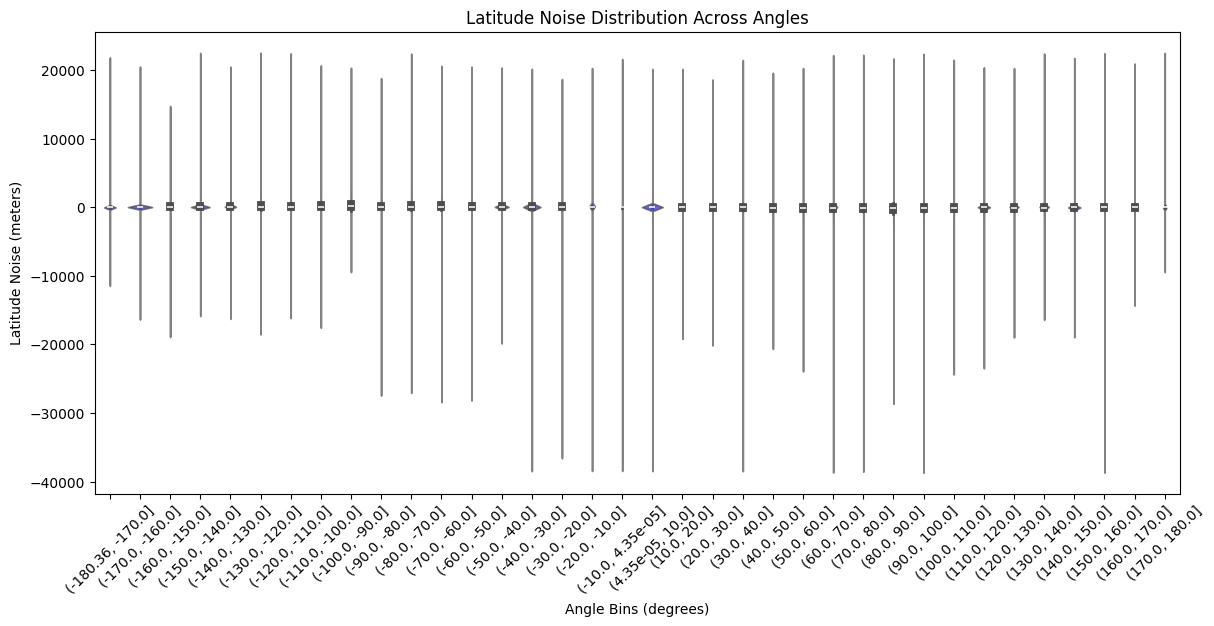

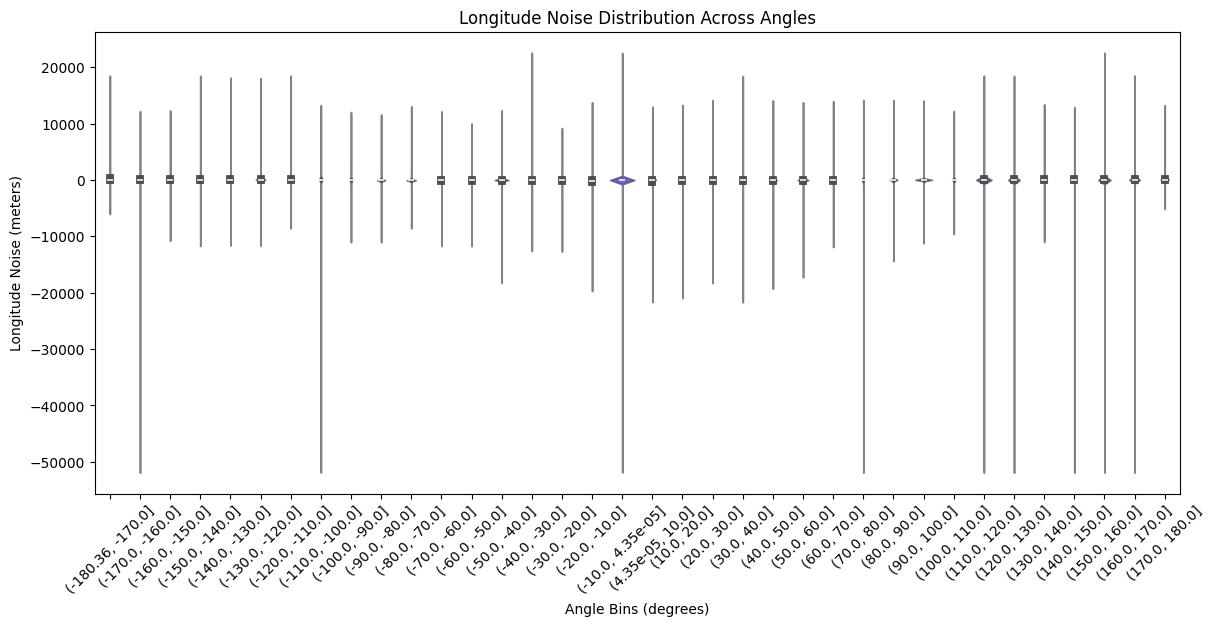

In [19]:
angles_deg = np.degrees(angles)

# Violin plot to show distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lat_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Latitude Noise (meters)")
plt.title("Latitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x=pd.cut(angles_deg, bins=36), y=lon_noise, color="blue", alpha=0.7)
plt.xlabel("Angle Bins (degrees)")
plt.ylabel("Longitude Noise (meters)")
plt.title("Longitude Noise Distribution Across Angles")
plt.xticks(rotation=45)
plt.show()


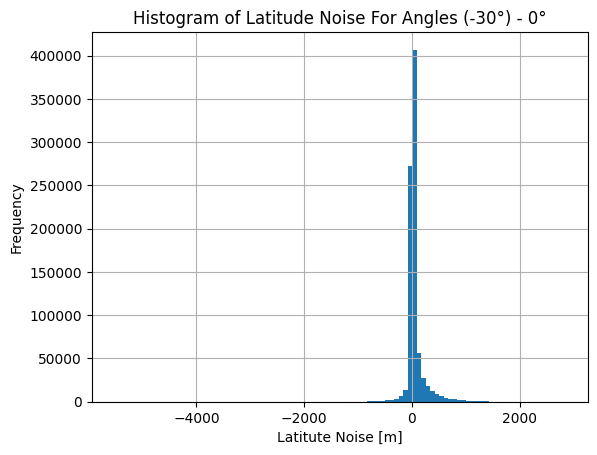

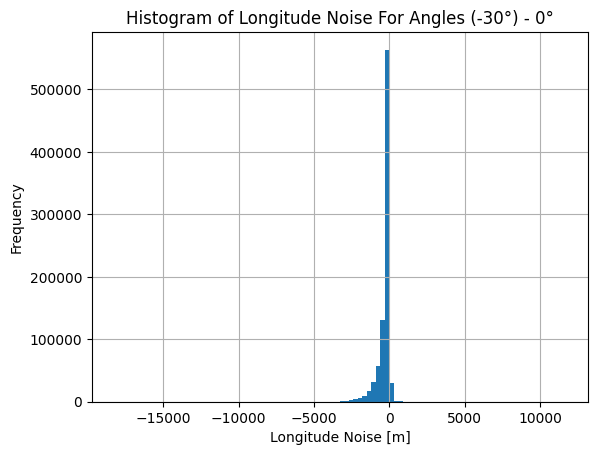

In [ ]:
#angle range
angle_min = -30
angle_max = 0

selected_indices = (angles_deg >= angle_min) & (angles_deg < angle_max)
selected_lon_noise = np.array(lon_noise)[selected_indices]
selected_lat_noise = np.array(lat_noise)[selected_indices]

plt.hist(selected_lat_noise, bins=100)
plt.xlabel("Latitute Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Latitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()

plt.hist(selected_lon_noise, bins=100)
plt.xlabel("Longitude Noise [m]")
plt.ylabel("Frequency")
plt.title(f"Histogram of Longitude Noise For Angles ({angle_min}°) - {angle_max}°")
plt.grid()
plt.show()
